# Tensorflow/Keras based Pos Rec in XENON1T

  * Yuehuan and Fei, Dec 2017

** News Maps in Training:**
  * Using the latest MC v2.1.0 version from Lutz.
  * Considering the PMT's R/Angular-dependent collection efficiency (Qing).
  * Higher statistic in large Radius in training samples. 

In [23]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# Common imports
import numpy as np
import pickle
import numpy.random as rnd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import json
print (tf.__version__)

1.4.1


## Import Keras

In [2]:
# Libs for Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Conv1D, Convolution1D, GlobalMaxPooling1D, Convolution2D, GlobalMaxPooling2D, MaxPooling1D
from keras.preprocessing import sequence
from keras.models import model_from_json
from keras.callbacks import History 

Using TensorFlow backend.


In [24]:
def save_model(bad_PMT_list, your_model, name='your_model'):
    model_json = your_model.to_json()
    model_path='./trained_models/'
    # Saving our model to Jason file for later use
    with open(model_path+name+'.json', "w") as json_file:
        json_file.write(model_json)
    json_data = json.load(open(model_path+name+'.json', "r"))
    json_data['badPMTList'] = bad_PMT_list
    json.dump(json_data, open(model_path+name+'.json','w'))
    your_model.save_weights(model_path+name+'.h5')
    print("Saved model to disk:", name)

##
def load_model(name='your_model'):
    # load json and create model
    model_path='./trained_models/'
    json_file = open(model_path+name+'.json', 'r')
    loaded_model_json = json_file.read()   
    json_file.close()
    loaded_model = model_from_json(str(loaded_model_json))
    # load weights into new model
    loaded_model.load_weights(model_path+name+'.h5')
    print("Loaded model from disk:",name)
    # evaluate loaded model on test data
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')
    # save bad PMT list
    json_file = open(model_path+name+'.json', 'r')
    loaded_model_json_dict = json.load(json_file)
    json_file.close()
    return loaded_model, loaded_model_json_dict

## Load new S2 Maps:

###  1) prepare training samples:

In [4]:
from pandas import read_hdf
df_uzh= read_hdf('/project2/lgrandi/qinglin/NewPosRecSamples_171211/AngularDependence_Plus_RDependenceZurich/WithAngularDependenceAndZurichRDependence.h5', 'table')
print (len(df_uzh))

989875


#### Impement QEs:
Set QE at zero for dead PMTs, difference for SR0 and SR1.

In [5]:
sr0_QE = np.loadtxt('/home/yuehuan/TensorFlow/NewMaps/sr0_norm_PMT_QE.txt')
sr1_QE = np.loadtxt('/home/yuehuan/TensorFlow/NewMaps/sr1_norm_PMT_QE.txt')

** selecting 800,000 events as training samples, left 100,000 (in 18,9875) events for testing**

In [6]:
df_uzh_training = df_uzh[(df_uzh.index < 800000)]
df_uzh_testing  = df_uzh[(df_uzh.index >= 800000) & (df_uzh.index < 900000)]

In [7]:
print (len(df_uzh_training))
print (len(df_uzh_testing))

800000
100000


  * **add more events on the edge ...**

In [8]:
df_edge= read_hdf('/project2/lgrandi/qinglin/NewPosRecSamples_171211/AngularDependence_Plus_RDependenceZurich_Extra/AngularDependence_Plus_RDependenceZurich_Extra.h5', 'table')
df_edge = df_edge[(df_edge.x**2 + df_edge.y**2 > 420**2)]
print (len(df_edge))

232546


**Merging uniform and edge events together as training samples:**

In [9]:
df_com = pd.concat([df_uzh_training, df_edge], ignore_index=True)

In [10]:
print (len(df_com))
df_com.head(2)

1032546


,S2_PMT_0,S2_PMT_1,S2_PMT_10,S2_PMT_100,S2_PMT_101,S2_PMT_102,S2_PMT_103,S2_PMT_104,S2_PMT_105,S2_PMT_106,...,S2_PMT_92,S2_PMT_93,S2_PMT_94,S2_PMT_95,S2_PMT_96,S2_PMT_97,S2_PMT_98,S2_PMT_99,x,y
0,3.113553,2.314306,0.760218,2.983650,4.58612,2.327590,4.430299,4.783083,14.421457,9.643715,...,6.293903,3.868554,2.277533,1.511398,0.819523,1.591735,3.097676,1.520878,-51.301502,63.561474
1,260.184800,159.799802,0.757192,0.855927,0.00000,3.070147,3.126584,0.796700,1.528899,5.428714,...,4.488889,2.871482,1.476158,3.769332,2.289000,0.000000,0.797423,2.103747,-96.469803,462.109436


#### sort the PMT ID:

In [11]:
columns = []
for i in range(127):
    columns.append('S2_PMT_'+str(i))
columns.append('x')
columns.append('y')

In [12]:
df_com = df_com[columns]

In [13]:
for i in range(127):
    df_com['S2_PMT_'+str(i)] = df_com['S2_PMT_'+str(i)]*sr1_QE[i][1]

In [14]:
df_pos = df_com
df_pos['s2top'] = sum([(df_pos['S2_PMT_'+str(i)]) for i in range(127)])

In [15]:
pmthits = df_pos.loc[:,[c for c in df_pos.columns if 'PMT' in c]].values
list_bad_pmts = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 130, 134, 135, 
                 139, 148, 150, 152, 162, 178, 183, 190, 198, 206, 213, 214, 234, 
                 239, 244, 27, 73, 91, 137, 167, 203]

pmthits_clean = df_pos.loc[:,[c for i, c in enumerate(df_pos.columns) 
                              if 'PMT' in c and i not in list_bad_pmts]].values

target = df_pos[['x','y']].values
s2top = df_pos['s2top'].values
offset = 1e-5
for i in range(len(pmthits)):
    pmthits[i] /= s2top[i] 
    pmthits_clean[i] /= s2top[i]

pmthits[np.isnan(pmthits)] = 0
pmthits_clean[np.isnan(pmthits_clean)] = 0
pmthits += offset
pmthits_clean += offset

print (pmthits[10000].sum())

1.00127


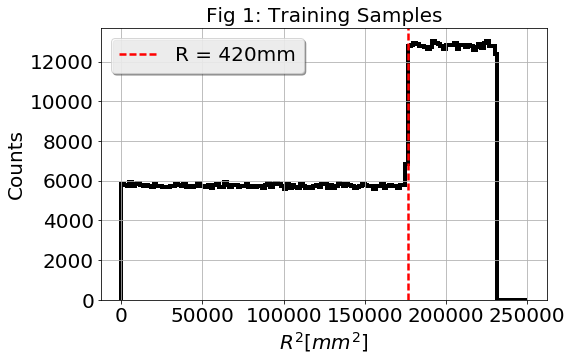

In [50]:
fig_sig= plt.figure(figsize = (8,5))

plt.hist(df_pos.x**2 + df_pos.y**2,
         range=(0, 250000), bins=150,
         color='black', histtype='step', linestyle='solid', linewidth=4,
         label='')

plt.title('Fig 1: Training Samples', fontsize = 20)

plt.xlabel(r'$R^{2}[mm^{2}]$', fontsize =20)
plt.ylabel(r'Counts', fontsize =20)
plt.grid(True)

plt.axvline(420**2, color='red', linestyle='--', linewidth = 2.5, label = 'R = 420mm')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

legend = plt.legend(loc='upper left', shadow=True, fontsize = 20)

plt.show()

### 2) prepare testing samples:

In [17]:
df_uzh_testing = df_uzh_testing[columns]

for i in range(127):
    df_uzh_testing['S2_PMT_'+str(i)] = df_uzh_testing['S2_PMT_'+str(i)]*sr1_QE[i][1]

df_uzh_testing['s2top'] = sum([(df_uzh_testing['S2_PMT_'+str(i)]) for i in range(127)])

pmthits_test = df_uzh_testing.loc[:,[c for c in df_uzh_testing.columns if 'PMT' in c]].values
list_bad_pmts = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 130, 134, 135, 
                 139, 148, 150, 152, 162, 178, 183, 190, 198, 206, 213, 214, 234, 
                 239, 244, 27, 73, 91, 137, 167, 203]

pmthits_test_clean = df_uzh_testing.loc[:,[c for i, c in enumerate(df_uzh_testing.columns) 
                              if 'PMT' in c and i not in list_bad_pmts]].values

target_test = df_uzh_testing[['x','y']].values
s2top_test = df_uzh_testing['s2top'].values
offset = 1e-5
for i in range(len(pmthits_test)):
    pmthits_test[i] /= s2top_test[i] 
    pmthits_test_clean[i] /= s2top_test[i]

pmthits_test[np.isnan(pmthits_test)] = 0
pmthits_test_clean[np.isnan(pmthits_test_clean)] = 0
pmthits_test += offset
pmthits_test_clean += offset

print (pmthits_test[10000].sum())

1.00127


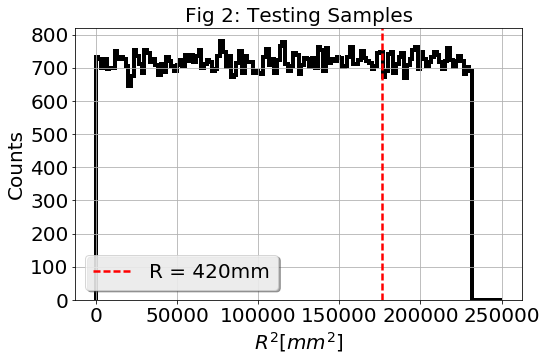

In [49]:
fig_sig= plt.figure(figsize = (8,5))

plt.hist(df_uzh_testing.x**2 + df_uzh_testing.y**2,
         range=(0, 250000), bins=150,
         color='black', histtype='step', linestyle='solid', linewidth=4,
         label='')

plt.title('Fig 2: Testing Samples', fontsize = 20)
plt.xlabel(r'$R^{2}[mm^{2}]$', fontsize =20)
plt.ylabel(r'Counts', fontsize =20)
plt.grid(True)

#-------------------------------------------------------------------->
plt.axvline(420**2, color='red', linestyle='--', linewidth = 2.5, label = 'R = 420mm')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

legend = plt.legend(loc='lower left', shadow=True, fontsize = 20)

plt.show()

### 3) training/testing samples:

In [19]:
batch_size = 100
epochs = 50
x_train_pos = pmthits_clean[:]
y_train_pos = target[:]
x_test_pos = pmthits_test_clean[:]
y_test_pos = target_test[:]

In [39]:
# define the model
def MLP(activation='elu', 
        reg_scale=0.001, # Regularization on coefficients
        keep_rate=0.00005,  # The smaller the keep rate, the better the performance is
        noutput=2):
    
    # parameters 100, 80, 60, 20
    hidden = [100,80,40,20] # hidden layers to use, for reference, Yuehuan used [32,28]
    # create sequential model
    model = Sequential() 
    model.add(Dense(len(x_train_pos[0]), input_dim=len(x_train_pos[0]))) # Input layer
    for hid in hidden:
        model.add(Dense(hid, kernel_initializer='normal', activation=activation, bias_initializer='zeros', use_bias=True, kernel_regularizer = regularizers.l2(reg_scale)))
        model.add(Dropout(keep_rate))
    model.add(Dense(noutput)) # Output layer
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
mlp_model = MLP() #KerasRegressor(build_fn=MLP, epochs=10, batch_size=50, verbose=1)
mlp_model.summary()
history = History()
hist = mlp_model.fit(x_train_pos, y_train_pos, batch_size=batch_size, validation_split=0.1, epochs=epochs, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 112)               12656     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               11300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 40)                3240      
_________________________________________________________________
dropout_7 (Dropout)          (None, 40)                0         
__________

In [41]:
save_model(list_bad_pmts, mlp_model,'mlp_model')
mlp, test = load_model('mlp_model')

Saved model to disk: mlp_model
Loaded model from disk: mlp_model


In [57]:
#print out bad PMT List:
#test['badPMTList']

#print out history:
print(hist.history)

{'val_loss': [78.521870584697112, 55.639168959369115, 40.391221713340919, 36.064614465765317, 34.41718982099696, 33.199151248829367, 30.713086424113577, 33.570664316648134, 28.794170017029078, 29.915382976918977, 26.315456016503212, 27.2953933185483, 26.64284336458978, 30.446413772215042, 26.186088930532421, 31.77124345334331, 24.749494653932409, 24.6872064663327, 25.10426187693054, 25.370918094930012, 27.006781813815618, 25.378942294834509, 23.811941256113741, 23.915708980954683, 25.021627985301432, 24.244556922334418, 29.781515137253706, 23.64235437354489, 24.014712390250359, 25.212449904440863, 25.05099627444152, 23.998419758748341, 24.142194975964308, 25.111619405149344, 25.196980309159663, 23.466851821159786, 26.906581045380459, 25.15391061745985, 24.540544373655106, 22.84809717892573, 24.498212385775652, 23.405988098524318, 24.08356177374489, 23.725063295527399, 23.046203024664095, 24.635553313343006, 22.937248561002573, 22.600803456983694, 23.811627704752809, 22.318663616271856]

In [60]:
x = np.linspace(1, 50, 50)
val_loss = hist.history['val_loss']
loss = hist.history['loss']

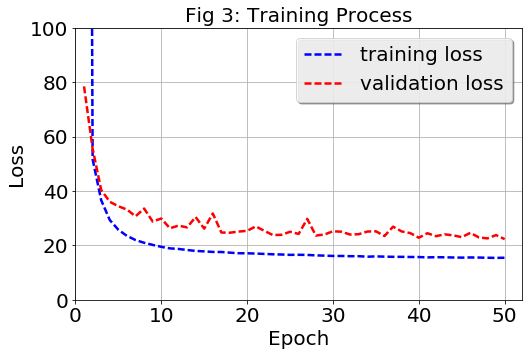

In [70]:
fig_sig= plt.figure(figsize = (8,5))

#--------------------------------------------------------------------->
plt.plot(x,loss,label='training loss', color='blue', linestyle = '--', lw=2.5)
plt.plot(x,val_loss,label='validation loss', color='red', linestyle = '--', lw=2.5)
#-------------------------------------------------------------------->
plt.title(r'Fig 3: Training Process', fontsize = 20)
plt.xlim(0,52)
plt.ylim(0, 100)

plt.xlabel('Epoch', fontsize =20)
plt.ylabel('Loss', fontsize =20)
plt.grid(True)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

legend = plt.legend(loc='upper right', shadow=True, fontsize = 20)

plt.show()

## Reconstructed test events:

In [44]:
y_pred_te = mlp.predict(x_test_pos)
#y_pred_tr = mlp.predict(x_train_pos)

In [45]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates          # for plotting dates
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline
from scipy.optimize import curve_fit       # curve fitting libraries
import pandas as pd
from IPython.display import Image
from IPython.core.display import HTML 
from matplotlib.colors import LogNorm
from collections import defaultdict
from array import array

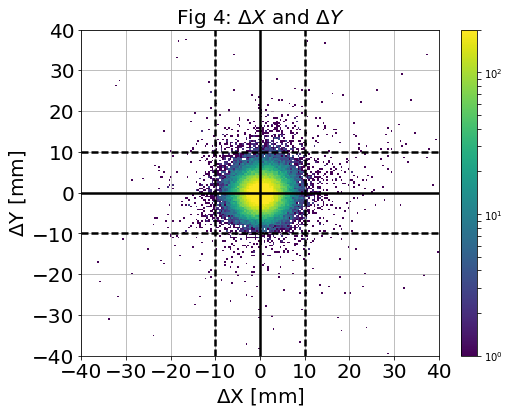

In [54]:
fig_sig= plt.figure(figsize = (8,6))

#--------------------------------------------------------------------->
plt.hist2d(y_pred_te[:,0]-y_test_pos[:,0],  y_pred_te[:,1]-y_test_pos[:,1], range=((-40, 40), (-40, 40)), bins=(200, 200), 
           norm=matplotlib.colors.LogNorm(), vmin=1, vmax=200)
plt.colorbar()

#-------------------------------------------------------------------->
plt.title(r'Fig 4: $\Delta X$ and $\Delta Y$', fontsize = 20)
plt.xlim(-40, 40)
plt.ylim(-40, 40)

plt.xlabel(r'$\Delta$X [mm]', fontsize =20)
plt.ylabel(r'$\Delta$Y [mm]', fontsize =20)
plt.grid(True)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.axvline(0, color='black', linestyle='-', linewidth = 2.5)
plt.axvline(-10, color='black', linestyle='--', linewidth = 2.5)
plt.axvline(10, color='black', linestyle='--', linewidth = 2.5)

plt.axhline(0, color='black', linestyle='-', linewidth = 2.5)
plt.axhline(-10, color='black', linestyle='--', linewidth = 2.5)
plt.axhline(10, color='black', linestyle='--', linewidth = 2.5)

plt.show()

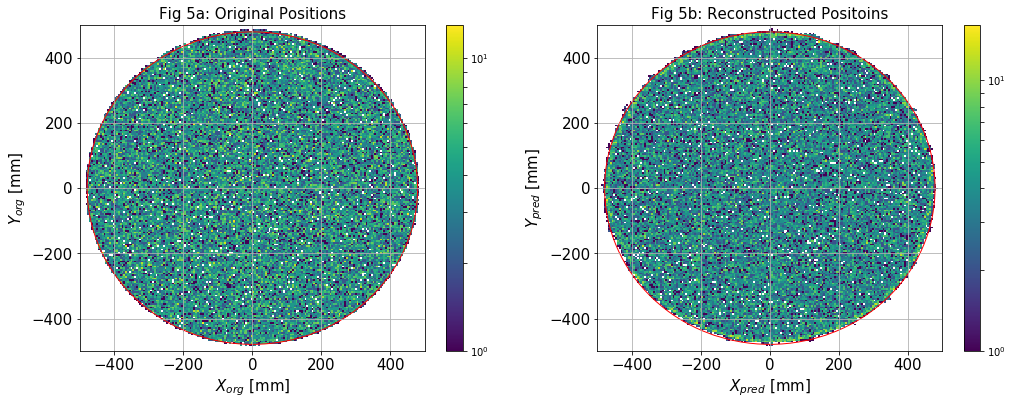

In [53]:
fig_sig= plt.figure(figsize = (17,6))

plt.subplot(121)
#--------------------------------------------------------------------->
plt.hist2d(y_test_pos[:,0], y_test_pos[:,1], range=((-520, 520), (-520, 520)), bins=(200, 200), 
           norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.gca().add_artist(plt.Circle((0, 0), 479, color='r', fill=None))
#-------------------------------------------------------------------->

plt.xlim(-500, 500)
plt.ylim(-500, 500)

plt.xlabel('$X_{org}$ [mm]', fontsize =15)
plt.ylabel('$Y_{org}$ [mm]', fontsize =15)
plt.grid(True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Fig 5a: Original Positions', fontsize = 15)

plt.subplot(122)
#--------------------------------------------------------------------->
plt.hist2d(y_pred_te[:,0], y_pred_te[:,1], range=((-520, 520), (-520, 520)), bins=(200, 200), 
           norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.gca().add_artist(plt.Circle((0, 0), 479, color='r', fill=None))
#-------------------------------------------------------------------->

plt.xlim(-500, 500)
plt.ylim(-500, 500)

plt.xlabel('$X_{pred}$ [mm]', fontsize =15)
plt.ylabel('$Y_{pred}$ [mm]', fontsize =15)
plt.grid(True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Fig 5b: Reconstructed Positoins', fontsize = 15)

plt.show()